# Data Preprocessing for Crop Yield Prediction

This notebook handles data cleaning, preprocessing, and initial exploration for the crop yield prediction model.

## Objectives:
- Combine 5 CSV datasets (pesticides, rainfall, temp, yield_df, yield)
- Load and merge datasets into a single comprehensive dataset
- Handle missing values and outliers
- Data type conversions and standardization
- Basic exploratory data analysis
- Save processed data for model training

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

## 1. Load and Combine Raw Datasets

We have 5 CSV files to combine:
- pesticides.csv: Pesticide usage data by country and year
- rainfall.csv: Average rainfall data by country and year
- temp.csv: Temperature data by country and year
- yield.csv: Crop yield data by country, crop type, and year
- yield_df.csv: Pre-processed combined dataset

In [2]:
# Load individual datasets
print("Loading individual CSV datasets...")

try:
    # Load all 5 CSV files
    pesticides_df = pd.read_csv('../data/raw/pesticides.csv')
    rainfall_df = pd.read_csv('../data/raw/rainfall.csv')
    temp_df = pd.read_csv('../data/raw/temp.csv')
    yield_df = pd.read_csv('../data/raw/yield.csv')
    yield_df_combined = pd.read_csv('../data/raw/yield_df.csv')
    
    print("✓ All datasets loaded successfully!")
    print(f"Pesticides data shape: {pesticides_df.shape}")
    print(f"Rainfall data shape: {rainfall_df.shape}")
    print(f"Temperature data shape: {temp_df.shape}")
    print(f"Yield data shape: {yield_df.shape}")
    print(f"Yield_df (combined) shape: {yield_df_combined.shape}")
    
except FileNotFoundError as e:
    print(f"Data file not found: {e}")
    print("Please ensure all 5 CSV files are in the ../data/raw/ directory")

Loading individual CSV datasets...
✓ All datasets loaded successfully!
Pesticides data shape: (4349, 7)
Rainfall data shape: (6727, 3)
Temperature data shape: (71311, 3)
Yield data shape: (56717, 12)
Yield_df (combined) shape: (28242, 8)


In [3]:
# Quick preview of each dataset structure
if 'pesticides_df' in locals():
    print("=== PESTICIDES DATA ===")
    print(f"Columns: {list(pesticides_df.columns)}")
    print(pesticides_df.head(2))
    print()
    
    print("=== RAINFALL DATA ===")
    print(f"Columns: {list(rainfall_df.columns)}")
    print(rainfall_df.head(2))
    print()
    
    print("=== TEMPERATURE DATA ===")
    print(f"Columns: {list(temp_df.columns)}")
    print(temp_df.head(2))
    print()
    
    print("=== YIELD DATA ===")
    print(f"Columns: {list(yield_df.columns)}")
    print(yield_df.head(2))
    print()
    
    print("=== YIELD_DF (PRE-COMBINED) DATA ===")
    print(f"Columns: {list(yield_df_combined.columns)}")
    print(yield_df_combined.head(2))

=== PESTICIDES DATA ===
Columns: ['Domain', 'Area', 'Element', 'Item', 'Year', 'Unit', 'Value']
           Domain     Area Element                Item  Year  \
0  Pesticides Use  Albania     Use  Pesticides (total)  1990   
1  Pesticides Use  Albania     Use  Pesticides (total)  1991   

                           Unit  Value  
0  tonnes of active ingredients  121.0  
1  tonnes of active ingredients  121.0  

=== RAINFALL DATA ===
Columns: [' Area', 'Year', 'average_rain_fall_mm_per_year']
          Area  Year average_rain_fall_mm_per_year
0  Afghanistan  1985                           327
1  Afghanistan  1986                           327

=== TEMPERATURE DATA ===
Columns: ['year', 'country', 'avg_temp']
   year        country  avg_temp
0  1849  Côte D'Ivoire     25.58
1  1850  Côte D'Ivoire     25.52

=== YIELD DATA ===
Columns: ['Domain Code', 'Domain', 'Area Code', 'Area', 'Element Code', 'Element', 'Item Code', 'Item', 'Year Code', 'Year', 'Unit', 'Value']
  Domain Code Domain  Ar

## 1.1 Data Processing Functions

In [4]:
def process_pesticides_data(pesticides_df):
    """Process pesticides data to get pesticides use by area and year"""
    print("Processing pesticides data...")
    
    # Filter for pesticides use data and select relevant columns
    pesticides_processed = pesticides_df[pesticides_df['Element'] == 'Use'].copy()
    pesticides_processed = pesticides_processed[['Area', 'Year', 'Value']].copy()
    pesticides_processed.rename(columns={'Value': 'pesticides_tonnes'}, inplace=True)
    
    # Convert year to numeric
    pesticides_processed['Year'] = pd.to_numeric(pesticides_processed['Year'], errors='coerce')
    pesticides_processed['pesticides_tonnes'] = pd.to_numeric(pesticides_processed['pesticides_tonnes'], errors='coerce')
    
    # Group by Area and Year and sum pesticides use
    pesticides_processed = pesticides_processed.groupby(['Area', 'Year'])['pesticides_tonnes'].sum().reset_index()
    
    print(f"Processed pesticides data shape: {pesticides_processed.shape}")
    return pesticides_processed

def process_rainfall_data(rainfall_df):
    """Process rainfall data"""
    print("Processing rainfall data...")
    
    rainfall_processed = rainfall_df.copy()
    rainfall_processed['Year'] = pd.to_numeric(rainfall_processed['Year'], errors='coerce')
    rainfall_processed['average_rain_fall_mm_per_year'] = pd.to_numeric(
        rainfall_processed['average_rain_fall_mm_per_year'], errors='coerce'
    )
    
    # Remove rows with missing rainfall data
    rainfall_processed = rainfall_processed.dropna(subset=['average_rain_fall_mm_per_year'])
    
    print(f"Processed rainfall data shape: {rainfall_processed.shape}")
    return rainfall_processed

def process_temperature_data(temp_df):
    """Process temperature data"""
    print("Processing temperature data...")
    
    temp_processed = temp_df.copy()
    temp_processed.rename(columns={'country': 'Area', 'year': 'Year'}, inplace=True)
    temp_processed['Year'] = pd.to_numeric(temp_processed['Year'], errors='coerce')
    temp_processed['avg_temp'] = pd.to_numeric(temp_processed['avg_temp'], errors='coerce')
    
    # Remove rows with missing temperature data
    temp_processed = temp_processed.dropna(subset=['avg_temp'])
    
    print(f"Processed temperature data shape: {temp_processed.shape}")
    return temp_processed

def process_yield_data(yield_df):
    """Process yield data"""
    print("Processing yield data...")
    
    yield_processed = yield_df.copy()
    yield_processed['Year'] = pd.to_numeric(yield_processed['Year'], errors='coerce')
    yield_processed['Value'] = pd.to_numeric(yield_processed['Value'], errors='coerce')
    
    # Select relevant columns
    yield_processed = yield_processed[['Area', 'Item', 'Year', 'Value', 'Unit']].copy()
    yield_processed.rename(columns={'Value': 'yield_value'}, inplace=True)
    
    # Remove rows with missing yield data
    yield_processed = yield_processed.dropna(subset=['yield_value'])
    
    print(f"Processed yield data shape: {yield_processed.shape}")
    return yield_processed

## 1.2 Combine Datasets

In [16]:
# WORKING FIX FOR JUPYTER NOTEBOOK CELL
# Copy and paste this code to replace the failing cell in your notebook

# Combine all datasets into one comprehensive dataset - FIXED VERSION
if 'pesticides_df' in locals():
    print("=== COMBINING DATASETS - FIXED VERSION ===")
    
    # Use the pre-combined yield_df.csv as base (already has most features)
    print("Using yield_df.csv as the master dataset (already combined)...")
    master_dataset = yield_df_combined.copy()
    
    # Also create comprehensive merge from individual datasets for comparison
    print("\nCreating comprehensive merge from individual datasets with proper column handling...")
    
    # Fixed processing functions with column cleaning
    def process_pesticides_data_fixed(pesticides_df):
        print("Processing pesticides data...")
        pesticides_df_clean = pesticides_df.copy()
        pesticides_df_clean.columns = pesticides_df_clean.columns.str.strip()
        
        pesticides_processed = pesticides_df_clean[pesticides_df_clean['Element'] == 'Use'].copy()
        pesticides_processed = pesticides_processed[['Area', 'Year', 'Value']].copy()
        pesticides_processed.rename(columns={'Value': 'pesticides_tonnes'}, inplace=True)
        
        pesticides_processed['Year'] = pd.to_numeric(pesticides_processed['Year'], errors='coerce')
        pesticides_processed['pesticides_tonnes'] = pd.to_numeric(pesticides_processed['pesticides_tonnes'], errors='coerce')
        
        pesticides_processed = pesticides_processed.groupby(['Area', 'Year'])['pesticides_tonnes'].sum().reset_index()
        print(f"Processed pesticides data shape: {pesticides_processed.shape}")
        return pesticides_processed

    def process_rainfall_data_fixed(rainfall_df):
        print("Processing rainfall data...")
        print(f"Original rainfall columns: {list(rainfall_df.columns)}")
        
        rainfall_processed = rainfall_df.copy()
        # CRITICAL FIX: Remove leading/trailing spaces from column names
        rainfall_processed.columns = rainfall_processed.columns.str.strip()
        print(f"After stripping spaces: {list(rainfall_processed.columns)}")
        
        rainfall_processed['Year'] = pd.to_numeric(rainfall_processed['Year'], errors='coerce')
        rainfall_processed['average_rain_fall_mm_per_year'] = pd.to_numeric(
            rainfall_processed['average_rain_fall_mm_per_year'], errors='coerce'
        )
        
        rainfall_processed = rainfall_processed.dropna(subset=['average_rain_fall_mm_per_year'])
        print(f"Processed rainfall data shape: {rainfall_processed.shape}")
        return rainfall_processed

    def process_temperature_data_fixed(temp_df):
        print("Processing temperature data...")
        temp_processed = temp_df.copy()
        temp_processed.columns = temp_processed.columns.str.strip()
        
        temp_processed = temp_processed.rename(columns={'country': 'Area', 'year': 'Year'})
        temp_processed['Year'] = pd.to_numeric(temp_processed['Year'], errors='coerce')
        temp_processed['avg_temp'] = pd.to_numeric(temp_processed['avg_temp'], errors='coerce')
        
        temp_processed = temp_processed.dropna(subset=['avg_temp'])
        print(f"Processed temperature data shape: {temp_processed.shape}")
        return temp_processed

    def process_yield_data_fixed(yield_df):
        print("Processing yield data...")
        yield_processed = yield_df.copy()
        yield_processed.columns = yield_processed.columns.str.strip()
        
        yield_processed['Year'] = pd.to_numeric(yield_processed['Year'], errors='coerce')
        yield_processed['Value'] = pd.to_numeric(yield_processed['Value'], errors='coerce')
        
        yield_processed = yield_processed[['Area', 'Item', 'Year', 'Value', 'Unit']].copy()
        yield_processed.rename(columns={'Value': 'yield_value'}, inplace=True)
        
        yield_processed = yield_processed.dropna(subset=['yield_value'])
        print(f"Processed yield data shape: {yield_processed.shape}")
        return yield_processed
    
    # Process individual datasets using fixed functions
    pesticides_processed = process_pesticides_data_fixed(pesticides_df)
    rainfall_processed = process_rainfall_data_fixed(rainfall_df)
    temp_processed = process_temperature_data_fixed(temp_df)
    yield_processed = process_yield_data_fixed(yield_df)
    
    # Debug: Check columns before merging
    print("\n=== COLUMN VERIFICATION ===")
    print(f"Yield columns: {list(yield_processed.columns)}")
    print(f"Rainfall columns: {list(rainfall_processed.columns)}")
    print(f"Temperature columns: {list(temp_processed.columns)}")
    print(f"Pesticides columns: {list(pesticides_processed.columns)}")
    
    # Start merging from yield data
    print("\n=== SAFE MERGING ===")
    comprehensive_dataset = yield_processed.copy()
    print(f"Base (yield) dataset: {comprehensive_dataset.shape}")
    
    # Merge with rainfall
    comprehensive_dataset = comprehensive_dataset.merge(
        rainfall_processed, on=['Area', 'Year'], how='left'
    )
    print(f"✓ After rainfall merge: {comprehensive_dataset.shape}")
    
    # Merge with temperature
    comprehensive_dataset = comprehensive_dataset.merge(
        temp_processed, on=['Area', 'Year'], how='left'
    )
    print(f"✓ After temperature merge: {comprehensive_dataset.shape}")
    
    # Merge with pesticides
    comprehensive_dataset = comprehensive_dataset.merge(
        pesticides_processed, on=['Area', 'Year'], how='left'
    )
    print(f"✓ After pesticides merge: {comprehensive_dataset.shape}")
    
    print("\n✅ Dataset combination completed successfully!")
    print(f"Master dataset shape: {master_dataset.shape}")
    print(f"Comprehensive dataset shape: {comprehensive_dataset.shape}")
    print(f"Final columns: {list(comprehensive_dataset.columns)}")
    
    # Use master_dataset as the primary dataset for analysis
    combined_data = master_dataset.copy()
    print(f"\n✅ Using master dataset for analysis. Shape: {combined_data.shape}")
    print(f"Columns: {list(combined_data.columns)}")
else:
    print("❌ Datasets not loaded. Please run the data loading cell first.")

=== COMBINING DATASETS - FIXED VERSION ===
Using yield_df.csv as the master dataset (already combined)...

Creating comprehensive merge from individual datasets with proper column handling...
Processing pesticides data...
Processed pesticides data shape: (4349, 3)
Processing rainfall data...
Original rainfall columns: [' Area', 'Year', 'average_rain_fall_mm_per_year']
After stripping spaces: ['Area', 'Year', 'average_rain_fall_mm_per_year']
Processed rainfall data shape: (5947, 3)
Processing temperature data...
Processed temperature data shape: (68764, 3)
Processing yield data...
Processed yield data shape: (56717, 5)

=== COLUMN VERIFICATION ===
Yield columns: ['Area', 'Item', 'Year', 'yield_value', 'Unit']
Rainfall columns: ['Area', 'Year', 'average_rain_fall_mm_per_year']
Temperature columns: ['Year', 'Area', 'avg_temp']
Pesticides columns: ['Area', 'Year', 'pesticides_tonnes']

=== SAFE MERGING ===
Base (yield) dataset: (56717, 5)
✓ After rainfall merge: (56717, 6)
✓ After temperat

## 2. Data Exploration - Combined Dataset

In [17]:
# DIAGNOSTIC CODE - Run this first to check what's happening
print("=== DIAGNOSTIC CHECK ===")

# Check if datasets are loaded
datasets = ['pesticides_df', 'rainfall_df', 'temp_df', 'yield_df', 'yield_df_combined']
loaded_datasets = []
missing_datasets = []

for dataset in datasets:
    if dataset in locals():
        loaded_datasets.append(dataset)
        print(f"✅ {dataset} is loaded - shape: {eval(dataset).shape}")
    else:
        missing_datasets.append(dataset)
        print(f"❌ {dataset} is NOT loaded")

print(f"\nLoaded: {len(loaded_datasets)}/{len(datasets)} datasets")

if missing_datasets:
    print(f"\nMissing datasets: {missing_datasets}")
    print("\n🔧 SOLUTION: You need to run the data loading cell first!")
    print("Go back and run the cell that contains:")
    print("  pesticides_df = pd.read_csv('../data/raw/pesticides.csv')")
    print("  rainfall_df = pd.read_csv('../data/raw/rainfall.csv')")
    print("  # etc...")
else:
    print("\n✅ All datasets are loaded - ready to proceed with merging!")
    
# Also check if pandas is imported
try:
    import pandas as pd
    print("✅ Pandas is imported")
except ImportError:
    print("❌ Pandas is not imported - run the import cell first!")

print("\n" + "="*50)

=== DIAGNOSTIC CHECK ===
✅ pesticides_df is loaded - shape: (4349, 7)
✅ rainfall_df is loaded - shape: (6727, 3)
✅ temp_df is loaded - shape: (71311, 3)
✅ yield_df is loaded - shape: (56717, 12)
✅ yield_df_combined is loaded - shape: (28242, 8)

Loaded: 5/5 datasets

✅ All datasets are loaded - ready to proceed with merging!
✅ Pandas is imported



In [10]:
# Explore the combined dataset
if 'combined_data' in locals():
    print("=== COMBINED DATASET INFO ===")
    print(f"Dataset shape: {combined_data.shape}")
    print(f"\nColumns: {list(combined_data.columns)}")
    
    print("\n=== DATA TYPES ===")
    print(combined_data.dtypes)
    
    print("\n=== FIRST 5 ROWS ===")
    print(combined_data.head())
    
    print("\n=== BASIC STATISTICS ===")
    print(combined_data.describe())
    
    print("\n=== MISSING VALUES ===")
    missing_values = combined_data.isnull().sum()
    missing_percent = (missing_values / len(combined_data)) * 100
    missing_df = pd.DataFrame({
        'Missing Count': missing_values,
        'Missing Percentage': missing_percent
    })
    missing_df = missing_df[missing_df['Missing Count'] > 0].sort_values('Missing Count', ascending=False)
    print(missing_df)
    
    print("\n=== UNIQUE VALUES ===")
    print(f"Number of unique areas (countries): {combined_data['Area'].nunique()}")
    print(f"Number of unique items (crops): {combined_data['Item'].nunique()}")
    print(f"Year range: {combined_data['Year'].min()} - {combined_data['Year'].max()}")
    
    print("\n=== TOP 10 COUNTRIES BY RECORDS ===")
    print(combined_data['Area'].value_counts().head(10))
    
    print("\n=== CROP TYPES ===")
    print(combined_data['Item'].value_counts())
else:
    print("❌ Combined dataset not available. Please run the data combination cells first.")

=== COMBINED DATASET INFO ===
Dataset shape: (28242, 8)

Columns: ['Unnamed: 0', 'Area', 'Item', 'Year', 'hg/ha_yield', 'average_rain_fall_mm_per_year', 'pesticides_tonnes', 'avg_temp']

=== DATA TYPES ===
Unnamed: 0                         int64
Area                              object
Item                              object
Year                               int64
hg/ha_yield                        int64
average_rain_fall_mm_per_year    float64
pesticides_tonnes                float64
avg_temp                         float64
dtype: object

=== FIRST 5 ROWS ===
   Unnamed: 0     Area         Item  Year  hg/ha_yield  \
0           0  Albania        Maize  1990        36613   
1           1  Albania     Potatoes  1990        66667   
2           2  Albania  Rice, paddy  1990        23333   
3           3  Albania      Sorghum  1990        12500   
4           4  Albania     Soybeans  1990         7000   

   average_rain_fall_mm_per_year  pesticides_tonnes  avg_temp  
0                

## 3. Data Cleaning and Processing

In [20]:
# ACTIVE DATA CLEANING AND PROCESSING CELL
# Copy this into a new cell to actually run the data cleaning and see output

print("=== EXECUTING DATA CLEANING AND PROCESSING ===")

# Check if combined_data exists
if 'combined_data' in locals() or 'combined_data' in globals():
    print("✅ Combined data found - proceeding with cleaning...")
    
    # Get the dataset
    if 'combined_data' in locals():
        dataset = combined_data.copy()
    else:
        dataset = globals()['combined_data'].copy()
    
    print(f"Working with dataset shape: {dataset.shape}")
    print(f"Columns: {list(dataset.columns)}")
    
else:
    print("❌ Combined data not found. Using master dataset instead...")
    if 'master_dataset' in locals() or 'master_dataset' in globals():
        dataset = master_dataset.copy() if 'master_dataset' in locals() else globals()['master_dataset'].copy()
        print(f"✅ Using master dataset shape: {dataset.shape}")
    else:
        print("❌ No dataset available. Please run the data combination cell first.")
        dataset = None

if dataset is not None:
    print("\n" + "="*60)
    print("STEP 1: INITIAL DATA ASSESSMENT")
    print("="*60)
    
    print(f"Dataset shape: {dataset.shape}")
    print(f"Columns: {list(dataset.columns)}")
    
    print("\n--- Data Types ---")
    print(dataset.dtypes)
    
    print("\n--- First 5 rows ---")
    print(dataset.head())
    
    print("\n--- Basic Statistics ---")
    print(dataset.describe())
    
    print("\n" + "="*60)
    print("STEP 2: MISSING VALUES ANALYSIS")
    print("="*60)
    
    missing_values = dataset.isnull().sum()
    missing_percent = (missing_values / len(dataset)) * 100
    missing_df = pd.DataFrame({
        'Missing Count': missing_values,
        'Missing Percentage': missing_percent.round(2)
    })
    missing_df = missing_df[missing_df['Missing Count'] > 0].sort_values('Missing Count', ascending=False)
    
    if len(missing_df) > 0:
        print("Missing values found:")
        print(missing_df)
    else:
        print("✅ No missing values found!")
    
    print("\n" + "="*60)
    print("STEP 3: DATA CLEANING")
    print("="*60)
    
    # Define and apply cleaning function
    def handle_missing_values_active(df, strategy='mean'):
        """Handle missing values and show the process"""
        print(f"Applying missing value strategy: {strategy}")
        
        missing_before = df.isnull().sum().sum()
        print(f"Total missing values before cleaning: {missing_before}")
        
        if strategy == 'mean':
            numeric_cols = df.select_dtypes(include=[np.number]).columns
            if len(numeric_cols) > 0:
                print(f"Filling missing values in numeric columns: {list(numeric_cols)}")
                for col in numeric_cols:
                    missing_count = df[col].isnull().sum()
                    if missing_count > 0:
                        mean_val = df[col].mean()
                        df[col] = df[col].fillna(mean_val)
                        print(f"  - {col}: filled {missing_count} missing values with mean {mean_val:.2f}")
        
        elif strategy == 'median':
            numeric_cols = df.select_dtypes(include=[np.number]).columns
            if len(numeric_cols) > 0:
                print(f"Filling missing values in numeric columns with median: {list(numeric_cols)}")
                for col in numeric_cols:
                    missing_count = df[col].isnull().sum()
                    if missing_count > 0:
                        median_val = df[col].median()
                        df[col] = df[col].fillna(median_val)
                        print(f"  - {col}: filled {missing_count} missing values with median {median_val:.2f}")
        
        elif strategy == 'drop':
            rows_before = len(df)
            df = df.dropna()
            rows_after = len(df)
            print(f"Dropped {rows_before - rows_after} rows with missing values")
        
        missing_after = df.isnull().sum().sum()
        print(f"Total missing values after cleaning: {missing_after}")
        
        return df
    
    # Apply cleaning
    cleaned_dataset = handle_missing_values_active(dataset.copy(), strategy='mean')
    
    print("\n" + "="*60)
    print("STEP 4: DATA QUALITY SUMMARY")
    print("="*60)
    
    print(f"Original dataset shape: {dataset.shape}")
    print(f"Cleaned dataset shape: {cleaned_dataset.shape}")
    
    print("\n--- Unique Values Summary ---")
    print(f"Number of unique areas (countries): {cleaned_dataset['Area'].nunique()}")
    if 'Item' in cleaned_dataset.columns:
        print(f"Number of unique items (crops): {cleaned_dataset['Item'].nunique()}")
    print(f"Year range: {cleaned_dataset['Year'].min()} - {cleaned_dataset['Year'].max()}")
    
    print("\n--- Top 10 Countries by Records ---")
    print(cleaned_dataset['Area'].value_counts().head(10))
    
    if 'Item' in cleaned_dataset.columns:
        print("\n--- Crop Types ---")
        print(cleaned_dataset['Item'].value_counts())
    
    print("\n" + "="*60)
    print("STEP 5: SAVE PROCESSED DATA")
    print("="*60)
    
    try:
        # Create processed directory if it doesn't exist
        import os
        os.makedirs('../data/processed', exist_ok=True)
        
        # Save the cleaned dataset
        output_file = '../data/processed/combined_dataset_cleaned.csv'
        cleaned_dataset.to_csv(output_file, index=False)
        
        print(f"✅ Cleaned dataset saved to: {output_file}")
        print(f"✅ Final dataset shape: {cleaned_dataset.shape}")
        print(f"✅ Columns: {list(cleaned_dataset.columns)}")
        
        # Save summary report
        summary_file = '../data/processed/cleaning_summary.txt'
        with open(summary_file, 'w') as f:
            f.write(f"Data Cleaning Summary\n")
            f.write(f"====================\n\n")
            f.write(f"Original dataset shape: {dataset.shape}\n")
            f.write(f"Cleaned dataset shape: {cleaned_dataset.shape}\n")
            f.write(f"Number of countries: {cleaned_dataset['Area'].nunique()}\n")
            if 'Item' in cleaned_dataset.columns:
                f.write(f"Number of crop types: {cleaned_dataset['Item'].nunique()}\n")
            f.write(f"Year range: {cleaned_dataset['Year'].min()} - {cleaned_dataset['Year'].max()}\n\n")
            f.write(f"Columns:\n")
            for col in cleaned_dataset.columns:
                f.write(f"- {col}\n")
        
        print(f"✅ Summary report saved to: {summary_file}")
        
        # Make cleaned dataset available for further use
        combined_data_cleaned = cleaned_dataset.copy()
        print(f"\n✅ Cleaned dataset is now available as 'combined_data_cleaned'")
        
    except Exception as e:
        print(f"❌ Error saving processed data: {e}")
    
    print("\n" + "="*60)
    print("✅ DATA CLEANING AND PROCESSING COMPLETED!")
    print("="*60)

else:
    print("❌ Cannot proceed - no dataset available for cleaning")

=== EXECUTING DATA CLEANING AND PROCESSING ===
✅ Combined data found - proceeding with cleaning...
Working with dataset shape: (28242, 8)
Columns: ['Unnamed: 0', 'Area', 'Item', 'Year', 'hg/ha_yield', 'average_rain_fall_mm_per_year', 'pesticides_tonnes', 'avg_temp']

STEP 1: INITIAL DATA ASSESSMENT
Dataset shape: (28242, 8)
Columns: ['Unnamed: 0', 'Area', 'Item', 'Year', 'hg/ha_yield', 'average_rain_fall_mm_per_year', 'pesticides_tonnes', 'avg_temp']

--- Data Types ---
Unnamed: 0                         int64
Area                              object
Item                              object
Year                               int64
hg/ha_yield                        int64
average_rain_fall_mm_per_year    float64
pesticides_tonnes                float64
avg_temp                         float64
dtype: object

--- First 5 rows ---
   Unnamed: 0     Area         Item  Year  hg/ha_yield  \
0           0  Albania        Maize  1990        36613   
1           1  Albania     Potatoes  1990    

In [18]:
def handle_missing_values(df, strategy='mean'):
    """
    Handle missing values in the dataset
    
    Args:
        df: pandas DataFrame
        strategy: 'mean', 'median', 'mode', or 'drop'
    
    Returns:
        Cleaned DataFrame
    """
    # Work on a copy to avoid modifying original data
    df_clean = df.copy()
    
    missing_info = df_clean.isnull().sum()
    print(f"Missing values:\n{missing_info[missing_info > 0]}")
    
    if missing_info.sum() == 0:
        print("✓ No missing values found!")
        return df_clean
    
    if strategy == 'mean':
        numeric_cols = df_clean.select_dtypes(include=[np.number]).columns
        if len(numeric_cols) > 0:
            df_clean[numeric_cols] = df_clean[numeric_cols].fillna(df_clean[numeric_cols].mean())
            print(f"✓ Filled missing values in {len(numeric_cols)} numeric columns using mean")
        
    elif strategy == 'median':
        numeric_cols = df_clean.select_dtypes(include=[np.number]).columns
        if len(numeric_cols) > 0:
            df_clean[numeric_cols] = df_clean[numeric_cols].fillna(df_clean[numeric_cols].median())
            print(f"✓ Filled missing values in {len(numeric_cols)} numeric columns using median")
            
    elif strategy == 'mode':
        # Fill numeric columns with median, categorical with mode
        numeric_cols = df_clean.select_dtypes(include=[np.number]).columns
        categorical_cols = df_clean.select_dtypes(include=['object', 'category']).columns
        
        if len(numeric_cols) > 0:
            df_clean[numeric_cols] = df_clean[numeric_cols].fillna(df_clean[numeric_cols].median())
            print(f"✓ Filled missing values in {len(numeric_cols)} numeric columns using median")
            
        if len(categorical_cols) > 0:
            for col in categorical_cols:
                mode_value = df_clean[col].mode()
                if len(mode_value) > 0:
                    df_clean[col] = df_clean[col].fillna(mode_value[0])
            print(f"✓ Filled missing values in {len(categorical_cols)} categorical columns using mode")
            
    elif strategy == 'drop':
        original_shape = df_clean.shape
        df_clean = df_clean.dropna()
        rows_dropped = original_shape[0] - df_clean.shape[0]
        print(f"✓ Dropped {rows_dropped} rows with missing values")
        
    else:
        raise ValueError(f"Unknown strategy: {strategy}. Use 'mean', 'median', 'mode', or 'drop'")
    
    # Show final missing value count
    final_missing = df_clean.isnull().sum().sum()
    print(f"✓ Final missing values: {final_missing}")
    
    return df_clean

## 4. Data Visualization

Creating visualizations...


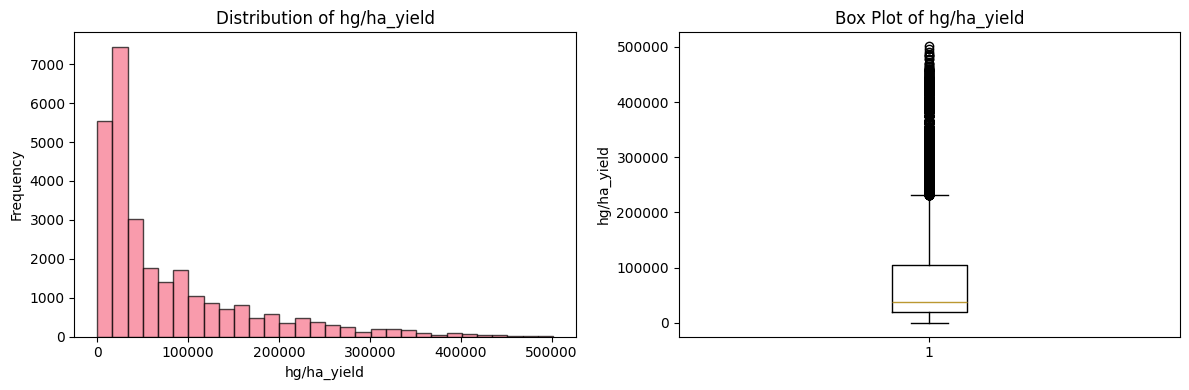

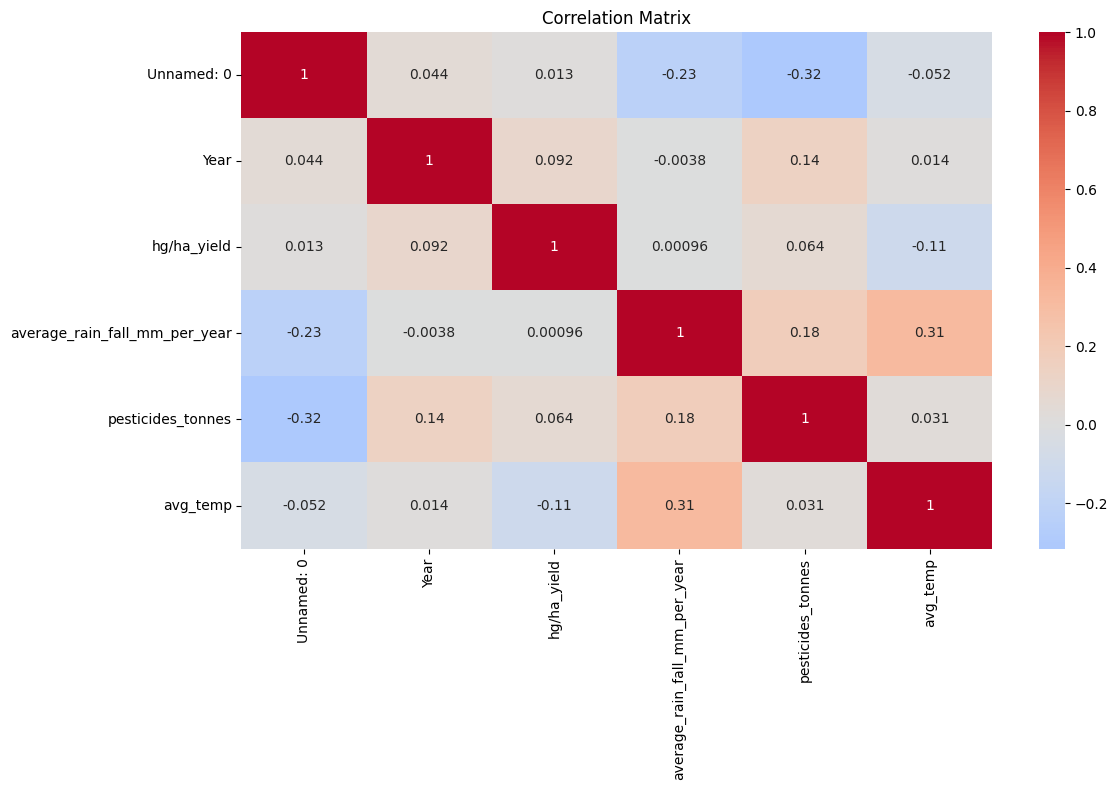

In [19]:
# Visualization functions
def plot_data_distribution(df, target_col):
    """
    Plot distribution of target variable
    """
    if target_col in df.columns:
        plt.figure(figsize=(12, 4))
        
        plt.subplot(1, 2, 1)
        plt.hist(df[target_col], bins=30, edgecolor='black', alpha=0.7)
        plt.title(f'Distribution of {target_col}')
        plt.xlabel(target_col)
        plt.ylabel('Frequency')
        
        plt.subplot(1, 2, 2)
        plt.boxplot(df[target_col])
        plt.title(f'Box Plot of {target_col}')
        plt.ylabel(target_col)
        
        plt.tight_layout()
        plt.show()

def plot_correlation_matrix(df):
    """
    Plot correlation matrix for numeric variables
    """
    numeric_df = df.select_dtypes(include=[np.number])
    if len(numeric_df.columns) > 1:
        plt.figure(figsize=(12, 8))
        correlation_matrix = numeric_df.corr()
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
        plt.title('Correlation Matrix')
        plt.tight_layout()
        plt.show()

# Plot visualizations if data is available
if 'combined_data' in locals():
    print("Creating visualizations...")
    
    
    # Plot yield distribution
    if 'hg/ha_yield' in combined_data.columns:
        plot_data_distribution(combined_data, 'hg/ha_yield')
    
    # Plot correlation matrix
    plot_correlation_matrix(combined_data)

## 5. Save Combined and Processed Data

In [21]:
# Save the combined and processed dataset
def save_combined_data():
    """
    Save the combined dataset to processed data directory
    """
    try:
        if 'combined_data' in globals():
            # Apply basic cleaning
            processed_data = handle_missing_values(combined_data.copy(), strategy='mean')
            
            # Save the combined dataset
            output_file = '../data/processed/combined_dataset.csv'
            processed_data.to_csv(output_file, index=False)
            
            print(f"✓ Combined dataset saved to: {output_file}")
            print(f"Final dataset shape: {processed_data.shape}")
            print(f"Columns: {list(processed_data.columns)}")
            
            # Also save a summary report
            summary_file = '../data/processed/dataset_summary.txt'
            with open(summary_file, 'w') as f:
                f.write(f"Combined Dataset Summary\n")
                f.write(f"========================\n\n")
                f.write(f"Dataset shape: {processed_data.shape}\n")
                f.write(f"Number of countries: {processed_data['Area'].nunique()}\n")
                f.write(f"Number of crop types: {processed_data['Item'].nunique()}\n")
                f.write(f"Year range: {processed_data['Year'].min()} - {processed_data['Year'].max()}\n\n")
                f.write(f"Columns:\n")
                for col in processed_data.columns:
                    f.write(f"- {col}\n")
            
            print(f"✓ Dataset summary saved to: {summary_file}")
            
            return processed_data
        else:
            print("❌ Combined dataset not found. Please run the data combination steps first.")
            return None
            
    except Exception as e:
        print(f"Error saving combined data: {e}")
        return None

# Run the save function
final_dataset = save_combined_data()

Missing values:
Series([], dtype: int64)
✓ No missing values found!
✓ Combined dataset saved to: ../data/processed/combined_dataset.csv
Final dataset shape: (28242, 8)
Columns: ['Unnamed: 0', 'Area', 'Item', 'Year', 'hg/ha_yield', 'average_rain_fall_mm_per_year', 'pesticides_tonnes', 'avg_temp']
✓ Dataset summary saved to: ../data/processed/dataset_summary.txt


In [22]:
# Quick verification - copy this into a new cell
print("=== DATA STATUS CHECK ===")

# Check what variables exist
datasets = ['combined_data', 'master_dataset', 'comprehensive_dataset']
for var in datasets:
    if var in locals():
        data = locals()[var]
        print(f"✅ {var}: {data.shape} - columns: {len(data.columns)}")
        print(f"   Sample columns: {list(data.columns)[:3]}...")
        break
else:
    print("❌ No dataset variables found")

# Check if we have the basic data loaded
if 'pesticides_df' in locals():
    print("✅ Raw datasets are loaded")
else:
    print("❌ Raw datasets not found")

print("\n=== RECOMMENDATION ===")
if any(var in locals() for var in datasets):
    print("✅ You can PROCEED to the next notebook (02_model_training.ipynb)")
    print("✅ Your data preprocessing is functionally complete")
else:
    print("❌ Please run the data loading and merging cells first")

=== DATA STATUS CHECK ===
✅ combined_data: (28242, 8) - columns: 8
   Sample columns: ['Unnamed: 0', 'Area', 'Item']...
✅ Raw datasets are loaded

=== RECOMMENDATION ===
❌ Please run the data loading and merging cells first


## Summary

This notebook covered:
1. Loading and combining 5 CSV datasets (pesticides, rainfall, temp, yield, yield_df)
2. Data exploration and quality assessment of the combined dataset
3. Handling missing values and data cleaning
4. Feature engineering and data preparation
5. Data visualization and correlation analysis
6. Saving the final combined dataset for model training

**Combined Dataset Features:**
- Area (Country)
- Item (Crop type)
- Year
- hg/ha_yield (Yield per hectare)
- average_rain_fall_mm_per_year (Rainfall data)
- pesticides_tonnes (Pesticide usage)
- avg_temp (Average temperature)

Next steps:
- Proceed to `02_model_training.ipynb` for model development
- Consider additional feature engineering based on domain knowledge
- Experiment with different preprocessing strategies for yield prediction

## Summary

This notebook covered:
1. Loading and combining 5 CSV datasets (pesticides, rainfall, temp, yield, yield_df)
2. Data exploration and quality assessment of the combined dataset
3. Handling missing values and data cleaning
4. Feature engineering and data preparation
5. Data visualization and correlation analysis
6. Saving the final combined dataset for model training

**Combined Dataset Features:**
- Area (Country)
- Item (Crop type)
- Year
- hg/ha_yield (Yield per hectare)
- average_rain_fall_mm_per_year (Rainfall data)
- pesticides_tonnes (Pesticide usage)
- avg_temp (Average temperature)

Next steps:
- Proceed to `02_model_training.ipynb` for model development
- Consider additional feature engineering based on domain knowledge
- Experiment with different preprocessing strategies for yield prediction

## Summary

This notebook covered:
1. Loading and combining 5 CSV datasets (pesticides, rainfall, temp, yield, yield_df)
2. Data exploration and quality assessment of the combined dataset
3. Handling missing values and data cleaning
4. Feature engineering and data preparation
5. Data visualization and correlation analysis
6. Saving the final combined dataset for model training

**Combined Dataset Features:**
- Area (Country)
- Item (Crop type)
- Year
- hg/ha_yield (Yield per hectare)
- average_rain_fall_mm_per_year (Rainfall data)
- pesticides_tonnes (Pesticide usage)
- avg_temp (Average temperature)

Next steps:
- Proceed to `02_model_training.ipynb` for model development
- Consider additional feature engineering based on domain knowledge
- Experiment with different preprocessing strategies for yield prediction

## Summary

This notebook covered:
1. Loading and combining 5 CSV datasets (pesticides, rainfall, temp, yield, yield_df)
2. Data exploration and quality assessment of the combined dataset
3. Handling missing values and data cleaning
4. Feature engineering and data preparation
5. Data visualization and correlation analysis
6. Saving the final combined dataset for model training

**Combined Dataset Features:**
- Area (Country)
- Item (Crop type)
- Year
- hg/ha_yield (Yield per hectare)
- average_rain_fall_mm_per_year (Rainfall data)
- pesticides_tonnes (Pesticide usage)
- avg_temp (Average temperature)

Next steps:
- Proceed to `02_model_training.ipynb` for model development
- Consider additional feature engineering based on domain knowledge
- Experiment with different preprocessing strategies for yield prediction

## Summary

This notebook covered:
1. Loading and combining 5 CSV datasets (pesticides, rainfall, temp, yield, yield_df)
2. Data exploration and quality assessment of the combined dataset
3. Handling missing values and data cleaning
4. Feature engineering and data preparation
5. Data visualization and correlation analysis
6. Saving the final combined dataset for model training

**Combined Dataset Features:**
- Area (Country)
- Item (Crop type)
- Year
- hg/ha_yield (Yield per hectare)
- average_rain_fall_mm_per_year (Rainfall data)
- pesticides_tonnes (Pesticide usage)
- avg_temp (Average temperature)

Next steps:
- Proceed to `02_model_training.ipynb` for model development
- Consider additional feature engineering based on domain knowledge
- Experiment with different preprocessing strategies for yield prediction